# Bengali Digits Recognition

In [0]:
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
IMAGE_CHANNELS = 1
NUM_CLASSES = 10
BATCH_SIZE = 20
EPOCHS = 30
NUM_CLASSES = 10

### Create CSV files

In [43]:
from sklearn.model_selection import train_test_split
import csv
import glob

digit_classes = ['0','1','2','3','4','5','6','7','8','9']

def create_csvs():
    train = []
    test = []
    total = []

    for myclass, directory in enumerate(digit_classes):
        for filename in glob.glob('data/{}/*.tif'.format(directory)):
            total.append([filename, myclass, directory])

    train,test = train_test_split(total)
    print('train', len(train))
    print('test', len(test))

    with open('train.csv', 'w') as csvfile:
        mywriter = csv.writer(csvfile)
        mywriter.writerow(['path', 'class', 'digit'])
        mywriter.writerows(train)
        print('Training CSV file created successfully')

    with open('test.csv', 'w') as csvfile:
        mywriter = csv.writer(csvfile)
        mywriter.writerow(['path', 'class', 'digit'])
        mywriter.writerows(test)
        print('Testing CSV file created successfully')

    print('CSV files created successfully')

create_csvs()


train 750
test 250
Training CSV file created successfully
Testing CSV file created successfully
CSV files created successfully


In [4]:
import numpy as np
import cv2
from keras.utils import to_categorical

def get_image(index, data):
    img = cv2.imread(data['path'].values[index].strip(),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    img = np.expand_dims(img, axis=-1)
    digit_class = data['class'].values[index]
    return img/255.0, digit_class

def make_image_gen(data, batch_size = BATCH_SIZE):
    while True:
        # Randomize the indices to make an array
        indices_arr = np.random.permutation(data.count()[0])
        for batch in range(0, len(indices_arr), batch_size):
            # slice out the current batch according to batch-size
            current_batch = indices_arr[batch:(batch + batch_size)]

            # initializing the arrays, x_train and y_train
            image_arr = np.empty([0, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], dtype=np.float32)

            y_train = np.empty([0], dtype=np.int32)

            for i in current_batch:
                # get image and its corresponding class(0,1,2,3,....,9)
                image, digit_class = get_image(i, data)
                image = np.expand_dims(image,axis=0)
#                 print(image.shape)

                # Appending them to existing batch
                image_arr = np.append(image_arr, image, axis=0)
                y_train = np.append(y_train, [digit_class])
                
            y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

            yield (image_arr, y_train)

Using TensorFlow backend.


## Make train Generator

In [5]:
import pandas as pd
import os
import cv2

# Read Dataset
d_train = pd.read_csv(os.path.join('train.csv'))
train_gen = make_image_gen(d_train)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (20, 28, 28, 1) 0.0 1.0
y (20, 10) 0.0 1.0


## Make Validation Generator

In [6]:
# Read Dataset
d_test = pd.read_csv(os.path.join('test.csv'))
test_gen = make_image_gen(d_train)
test_x, test_y = next(train_gen)
print('x', test_x.shape, test_x.min(), test_x.max())
print('y', test_y.shape, test_y.min(), test_y.max())

x (20, 28, 28, 1) 0.0 1.0
y (20, 10) 0.0 1.0


## Augment Data

In [0]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  brightness_range = [0.8,1.5],
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = False, 
                  vertical_flip = False,
                  fill_mode = 'nearest',
                  data_format = 'channels_last')

def create_aug_gen(in_gen, seed = None):
    image_gen = ImageDataGenerator(**dg_args)
    for in_x, in_y in in_gen:
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0],
                             shuffle=False)

        yield next(g_x)/255.0, in_y

## Test Augmentations

x (20, 28, 28, 1) float32 0.0 1.0
y (20, 10) float32 0.0 1.0


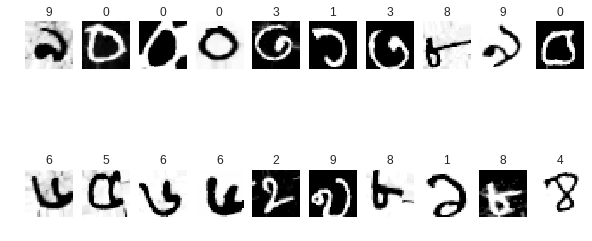

In [27]:
import matplotlib.pyplot as plt
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 20 samples to examine in detail
t_x = t_x[:20]
t_y = t_y[:20]
fig = plt.figure(figsize=(10,5))
for i in range(2):
  for j in range(10):
    plt.subplot(2,10,i*10 + j +1)
    plt.title(np.argmax(t_y[i*10 + j]))
    plt.imshow(np.reshape(t_x[i*10 + j],(IMAGE_HEIGHT,IMAGE_WIDTH)))
    plt.axis('off')
plt.show()

## Make LeNet Model

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten

def LeNet(input_shape):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))
  model.summary()
  return model

In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

model = LeNet((IMAGE_HEIGHT, IMAGE_WIDTH,IMAGE_CHANNELS))

checkpoint = ModelCheckpoint('LeNet.h5', monitor='val_loss',
                             verbose=1, save_best_only=True, mode='min', save_weights_only=False)
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)

callbacks_list = [checkpoint, reduceLROnPlat, earlyStop]
optim = Adam(lr=1e-4, decay=1e-6)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# train model
print('Training started....')

train_steps = len(d_train)//BATCH_SIZE
val_steps = len(d_test)//BATCH_SIZE

history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=val_steps,
    verbose=1,
    callbacks=callbacks_list,
    workers=1
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

## Evaluation

In [43]:
score = model.evaluate_generator(test_gen, steps=val_steps)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01896966869632403
Test accuracy: 1.0
